 ***Eshal Khan***
  
***SP23-BCS-095***

 **Mounting the Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the DataSet**

In [3]:
import pandas as pd

train_path = '/content/drive/MyDrive/AI-Lab(SP23-BCS-095)/archive (3)-20251210T044406Z-1-001/archive (3)/KDDTrain+.txt'
test_path  = '/content/drive/MyDrive/AI-Lab(SP23-BCS-095)/archive (3)-20251210T044406Z-1-001/archive (3)/KDDTest+.txt'

cols = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

train_df = pd.read_csv(train_path, names=cols)
test_df  = pd.read_csv(test_path,  names=cols)

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,udp,other,SF,146,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,tcp,private,S0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
0,tcp,http,SF,232,8153,0,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
0,tcp,http,SF,199,420,0,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


**Data Pre Process**

In [4]:
train_df['label_binary'] = train_df['label'].apply(lambda x: 0 if x=='normal' else 1)
test_df['label_binary']  = test_df['label'].apply(lambda x: 0 if x=='normal' else 1)

**Handle Categorical features with labelEncoding**

In [5]:
from sklearn.preprocessing import LabelEncoder

le_protocol = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

# Fit on combined values (train + test)
le_protocol.fit(pd.concat([train_df['protocol_type'], test_df['protocol_type']], axis=0))
le_service.fit(pd.concat([train_df['service'], test_df['service']], axis=0))
le_flag.fit(pd.concat([train_df['flag'], test_df['flag']], axis=0))

# Transform
train_df['protocol_type'] = le_protocol.transform(train_df['protocol_type'])
test_df['protocol_type'] = le_protocol.transform(test_df['protocol_type'])

train_df['service'] = le_service.transform(train_df['service'])
test_df['service'] = le_service.transform(test_df['service'])

train_df['flag'] = le_flag.transform(train_df['flag'])
test_df['flag'] = le_flag.transform(test_df['flag'])

**Split features and labels**

In [6]:
X_train = train_df.drop(['label','label_binary'], axis=1)
y_train = train_df['label_binary']

X_test  = test_df.drop(['label','label_binary'], axis=1)
y_test  = test_df['label_binary']

**Feature Scaling**

In [7]:
print(X_train.select_dtypes(include=['object']).columns)

Index(['duration', 'dst_host_srv_rerror_rate'], dtype='object')


In [8]:
cols_to_fix = ['duration', 'dst_host_srv_rerror_rate']

for col in cols_to_fix:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col]  = pd.to_numeric(X_test[col], errors='coerce')

# Fill any NaN created due to conversion
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

**MODEL 1 — Random Forest**

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     22544

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



**MODEL 2 — MLP Neural Network (ANN)**

In [11]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=20)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

MLP Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     22544

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



**Hybrid Model (Voting Classifier)**

In [12]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ensure labels are integers
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

# Fit base models
rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# Hybrid Voting Classifier - use HARD voting for binary classification
hybrid = VotingClassifier(
    estimators=[('rf', rf), ('mlp', mlp)],
    voting='hard'  # changed from soft to hard
)

hybrid.fit(X_train, y_train)
y_pred_hybrid = hybrid.predict(X_test)

# Evaluation
print("Hybrid Accuracy:", accuracy_score(y_test, y_pred_hybrid))
print(classification_report(y_test, y_pred_hybrid))

Hybrid Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     22544

    accuracy                           1.00     22544
   macro avg       1.00      1.00      1.00     22544
weighted avg       1.00      1.00      1.00     22544



**Graphs & Visualizations**

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


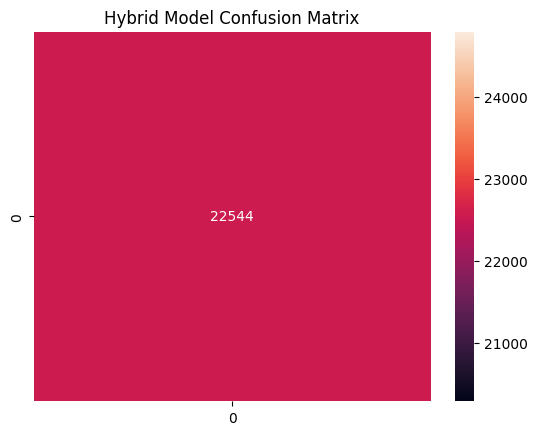

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Hybrid Model Confusion Matrix")
plt.savefig("/content/confusion_matrix.png")
plt.show()

**Comparison Bar Chart**

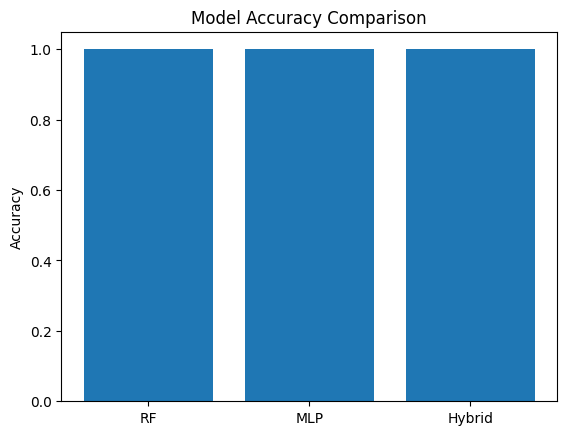

In [14]:
import numpy as np

accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_mlp),
    accuracy_score(y_test, y_pred_hybrid)
]

plt.bar(['RF','MLP','Hybrid'], accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.savefig("/content/accuracy_graph.png")
plt.show()